# [Sequence To Sequence](https://wikidocs.net/24996)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다.

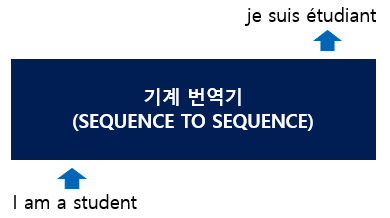

## Encoder
1. 인코더의 은닉 상태를 적절한 값(ex. 영벡터)으로 초기화한다.
2. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트를 한다.
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 된다.
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어간다.

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화한다.
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측한다. (최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.)
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행한다.

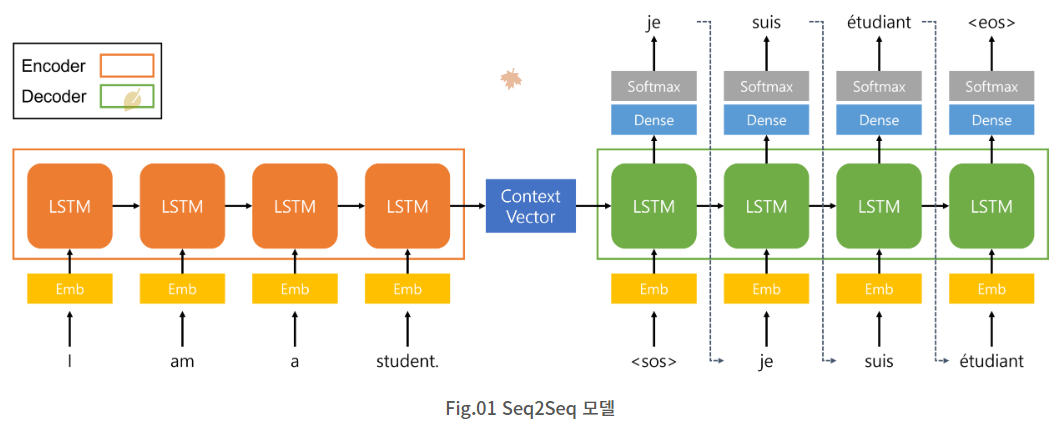

# 예제1

In [ ]:
import numpy as np
import torch
import torch.nn as nn

In [ ]:
n_step = 5 # 글자의 최대 길이
n_hidden = 128

## 데이터

### 데이터 생성

In [ ]:
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']]
np.array(seq_data).shape

(6, 2)

In [ ]:
batch_size = len(seq_data)
batch_size

6

### 데이터 토큰화

In [ ]:
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz'] # S(시작), E(끝), P(패딩)
len(char_arr)

29

### 데이터 사전

In [ ]:
num_dic = {n: i for i, n in enumerate(char_arr)}
n_class = len(num_dic)
n_class

29

In [ ]:
char_arr[5], num_dic['c']

('c', 5)

## 학습 데이터

### 학습 데이터 생성

In [ ]:
def make_batch():
    input_batch, output_batch, target_batch = [], [], []

    for seq in seq_data:
        for i in range(2):
            seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

        input = [num_dic[n] for n in seq[0]]
        output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
        target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

        input_batch.append(np.eye(n_class)[input]) # one-hot
        output_batch.append(np.eye(n_class)[output]) # one-hot
        target_batch.append(target) # not one-hot

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


In [ ]:
input_batch, output_batch, target_batch = make_batch()

# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(S) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

<ipython-input-8-9685e5fb509e>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

### 디버깅

In [ ]:
seq_data

[['manPP', 'women'],
 ['black', 'white'],
 ['kingP', 'queen'],
 ['girlP', 'boyPP'],
 ['upPPP', 'downP'],
 ['highP', 'lowPP']]

In [ ]:
# 1. 데이터 구조 파악 : 리스트1 , 리스트2
# 2. 리스트2에서 가장 큰 길이를 찾아서 새로운 리스트3에 담음
# 2-1. 리스트3: 리스트2에서 가장 큰 길이들이 모임
# 3. 리스트3에서 가장 큰 수 찾음
tmp = [ len(row[0]) if len(row[0]) > len(row[1]) else len(row[1]) for row in seq_data ]
tmp

[5, 5, 5, 5, 5, 5]

In [ ]:
max(tmp)

5

In [ ]:
n_step # 글자의 최대 길이

5

In [ ]:
for seq in [['man', 'women']]:
    for i in range(2):
        seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

    input = [num_dic[n] for n in seq[0]]
    output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
    target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

    break

In [ ]:
seq

['manPP', 'women']

In [ ]:
input

[15, 3, 16, 2, 2]

In [ ]:
output

[0, 25, 17, 15, 7, 16]

In [ ]:
target

[25, 17, 15, 7, 16, 1]

In [ ]:
len(np.eye(n_class)[input]) # 5개 글자!!!

5

In [ ]:
np.eye(n_class)[input][0] # 글자별 원핫인코딩!!

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Seq2Seq 모델 생성

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 인코딩
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 디코딩
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = enc_input.transpose(0, 1) # enc_input: [input_size, batch_size, embedding_size]
        dec_input = dec_input.transpose(0, 1) # dec_input: [input_size, batch_size, embedding_size]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)

        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states)

        _outputs = outputs.transpose(0, 1) # _outputs (batch_size, input_size(1(E) + 최대 글자 수), n_hidden)
        pred = self.fc(_outputs) # pred : [batch_size, max_len+1(=6), n_class]
        return pred

### 디버깅

In [ ]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(E) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [ ]:
n_class, n_hidden

(29, 128)

In [ ]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
fc = nn.Linear(n_hidden, n_class)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
enc_input = input_batch.transpose(0, 1)
# enc_input: (input_size(최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
enc_input.shape

torch.Size([5, 6, 29])

In [ ]:
dec_input = output_batch.transpose(0, 1)
# dec_input: (input_size(1(S) + 최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
dec_input.shape

torch.Size([6, 6, 29])

In [ ]:
enc_hidden = torch.zeros(1, batch_size, n_hidden) # 초기값
enc_hidden.shape

torch.Size([1, 6, 128])

In [ ]:
_, enc_states = enc_cell(enc_input, enc_hidden)
_.shape, enc_states.shape # enc_states (layer_size * num_directions, batch_size, n_hidden)

(torch.Size([5, 6, 128]), torch.Size([1, 6, 128]))

In [ ]:
outputs, _ = dec_cell(dec_input, enc_states)
outputs.shape, _.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, n_hidden)

(torch.Size([6, 6, 128]), torch.Size([1, 6, 128]))

In [ ]:
_outputs = outputs.transpose(0, 1) # outputs (batch_size, input_size(1(E) + 최대 글자 수), n_hidden)

In [ ]:
pred = fc(_outputs)
pred.shape # outputs (batch_size, input_size(1(E) + 최대 글자 수), embedding_size)

torch.Size([6, 6, 29])

## 학습

In [ ]:
model = Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

In [ ]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [ ]:
for epoch in range(5000):
    hidden = torch.zeros(1, batch_size, n_hidden)
    output = model(input_batch, hidden, output_batch)
    loss = 0
    for i in range(0, len(target_batch)):
        loss += criterion(output[i], target_batch[i])
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003246
Epoch: 2000 cost = 0.000878
Epoch: 3000 cost = 0.000373
Epoch: 4000 cost = 0.000187
Epoch: 5000 cost = 0.000101


## 테스트

In [ ]:
def make_testbatch(input_word):
    input_batch, output_batch = [], []

    input_w = input_word + 'P' * (n_step - len(input_word)) # P: 패딩 추가
    input = [num_dic[n] for n in input_w]
    output_w = 'S' + 'P' * n_step
    print(f'input_w: {input_w} / output_w: {output_w}')
    output = [num_dic[n] for n in output_w] # S와 P로 output 구성

    input_batch = np.eye(n_class)[input]
    output_batch = np.eye(n_class)[output]

    return torch.FloatTensor(input_batch).unsqueeze(0), torch.FloatTensor(output_batch).unsqueeze(0)

In [ ]:
n_step

5

In [ ]:
input_batch, output_batch = make_testbatch('black')
input_batch.shape, output_batch.shape

input_w: black / output_w: SPPPPP


(torch.Size([1, 5, 29]), torch.Size([1, 6, 29]))

In [ ]:
input_batch, output_batch = make_testbatch('upp')
input_batch.shape, output_batch.shape

input_w: uppPP / output_w: SPPPPP


(torch.Size([1, 5, 29]), torch.Size([1, 6, 29]))

In [ ]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape

torch.Size([1, 1, 128])

In [ ]:
output = model(input_batch, hidden, output_batch)
output.shape

torch.Size([1, 6, 29])

In [ ]:
output[0][0] # max: 16.0384

tensor([-1.9068,  0.1942, -2.6932, -0.3063,  1.6253, -0.9430, 15.0540,  2.1342,
        -0.8663, -0.7306, -0.1866, -3.4169, -1.5459, -1.0554,  3.5225, -1.8342,
         0.7851, -1.6429, -0.9521,  3.1635, -1.0525, -0.9825,  1.0573,  1.5228,
        -1.1223, -4.2911, -0.1271, -2.5930, -0.5154],
       grad_fn=<SelectBackward0>)

In [ ]:
output.data.max(2, keepdim=True) # values: 최대값, indices: 인덱스값

torch.return_types.max(
values=tensor([[[15.0540],
         [15.5350],
         [15.0454],
         [14.5348],
         [14.5992],
         [14.6244]]]),
indices=tensor([[[ 6],
         [17],
         [25],
         [16],
         [ 2],
         [ 1]]]))

In [ ]:
predict = output.data.max(2, keepdim=True)[1]
predict.shape

torch.Size([1, 6, 1])

In [ ]:
predict

tensor([[[ 6],
         [17],
         [25],
         [16],
         [ 2],
         [ 1]]])

In [ ]:
decoded = [char_arr[i] for i in predict[0]]
decoded # E: 문장의 끝을 나타냄, P: 패딩

['d', 'o', 'w', 'n', 'P', 'E']

In [ ]:
# Test
def translate(word):
    input_batch, output_batch = make_testbatch(word)

    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1(=6), batch_size(=1), n_class]

    predict = output.data.max(2, keepdim=True)[1] # select n_class dimension
    decoded = [char_arr[i] for i in predict[0]]
    end = decoded.index('E')
    translated = ''.join(decoded[:end])

    return translated.replace('P', '')

In [ ]:
print('test')
print('man ->', translate('man'))
print('mans ->', translate('mans'))
print('king ->', translate('king'))
print('black ->', translate('black'))
print('upp ->', translate('upp'))

test
input_w: manPP / output_w: SPPPPP
man -> women
input_w: mansP / output_w: SPPPPP
mans -> women
input_w: kingP / output_w: SPPPPP
king -> queen
input_w: black / output_w: SPPPPP
black -> white
input_w: uppPP / output_w: SPPPPP
upp -> down


# 예제2(영어->한글)

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

In [ ]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"


Mounted at /content/drive


In [ ]:
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")

print(train.shape)
train.head()

(5794, 2)


,en,ko
0,These products are of the same quality.,이 제품들은 같은 품질이다.
1,The meeting was cancelled.,미팅이 취소되었다.
2,They found this.,그들이 이것을 찾았다.
3,Tom didn't tell Mary why he had to work late.,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.
4,After you.,먼저 가세요.


## Text Preprocessing

### Cleaning
- 알파벳 , 숫자, 공백, 마침표, 쉼표, 느낌표, 물음표

In [ ]:
train["en"] = train["en"].str.replace("[^a-zA-Z0-9 .,!?\'\"]" , "",regex=True).str.lower()
train["ko"] = train["ko"].str.replace("[^가-힣0-9 .,!?\'\"]" , "",regex=True)

In [ ]:
train.head()

,en,ko
0,these products are of the same quality.,이 제품들은 같은 품질이다.
1,the meeting was cancelled.,미팅이 취소되었다.
2,they found this.,그들이 이것을 찾았다.
3,tom didn't tell mary why he had to work late.,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.
4,after you.,먼저 가세요.


### 토큰 & 어휘집

In [ ]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=cc3834020387115031cac20a949b1883eeb82585e105c0732bd4a4cb081461f1
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


#### 한글

In [ ]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [ ]:
result = kiwi.tokenize(train["ko"])

src_data = []
for tokens in result:
    tokens = [ t.form for t in tokens]
    src_data.append(tokens)

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

vocab_ko = build_vocab_from_iterator(src_data,specials=["<pad>","<unk>"])
vocab_ko.set_default_index(vocab_ko["<unk>"])
len(vocab_ko)

3245

In [ ]:
src_data = [ vocab_ko(tokens) for tokens in src_data ]
src_data[0]

[4, 2926, 32, 8, 50, 8, 3151, 4, 9, 2]

#### 영어

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [ ]:
sos_token = "<sos>"
eos_token = "<eos>"

In [ ]:
tgt_data = []
for text in train["en"]:
    tokens = [sos_token] + tokenizer(text) + [eos_token]
    tgt_data.append(tokens)

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

vocab_en = build_vocab_from_iterator(tgt_data,specials=["<pad>","<unk>",sos_token,eos_token])
vocab_en.set_default_index(vocab_en["<unk>"])
len(vocab_en)

3129

In [ ]:
tgt_data = [ vocab_en(tokens) for tokens in tgt_data]

## Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class TranslateDataset(Dataset):
    def __init__(self,src,tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self,idx):
        item = {}
        item["src"] = torch.tensor(self.src[idx])
        item["tgt"] = torch.tensor(self.tgt[idx])
        return item

In [ ]:
dt = TranslateDataset(src_data,tgt_data)
len(dt)

5794

In [ ]:
dt[0]

{'src': tensor([   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2]),
 'tgt': tensor([   2,  210, 2696,   29,   27,   11,  291, 1584,    4,    3])}

### collate_fn

- torch.nn.utils.rnn.pad_sequence
    - 첫번째 인수로 정수번호로 이루어진 1차원 텐서들을 담은 리스트 전달
    - 리스트 안의 텐서에 최대 길이에 맞춰 패딩해줘서 텐서로 반환
    - batch_first = True 주면 batch 차원을 앞에다가 넣어서 전달해도 된다.

In [ ]:
x = [ torch.tensor(lst) for lst in src_data[:4]]
x

[tensor([   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2]),
 tensor([1112,    4, 1255,   38,    6,    9,    2]),
 tensor([ 22,  32,   4,  87,  12, 209,   6,   9,   2]),
 tensor([ 10,   8,  49,  46,  84,  22,  13, 212,  41, 229,  58,   5,  48,   5,
           6, 103, 371,   3,  35,  21,  28,   6,   9,   2])]

In [ ]:
torch.nn.utils.rnn.pad_sequence(x,batch_first=True)

tensor([[   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [1112,    4, 1255,   38,    6,    9,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  22,   32,    4,   87,   12,  209,    6,    9,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  10,    8,   49,   46,   84,   22,   13,  212,   41,  229,   58,    5,
           48,    5,    6,  103,  371,    3,   35,   21,   28,    6,    9,    2]])

In [ ]:
def collate_fn(samples):
    # print(samples)
    src = [ sample["src"] for sample in samples ]
    tgt = [ sample["tgt"] for sample in samples ]

    src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
    tgt = torch.nn.utils.rnn.pad_sequence(tgt, batch_first=True)
    return {"src":src, "tgt":tgt }

## DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dl = DataLoader(dt,batch_size=2,shuffle=False,collate_fn=collate_fn)
batch = next(iter(dl))
batch

{'src': tensor([[   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2],
         [1112,    4, 1255,   38,    6,    9,    2,    0,    0,    0]]),
 'tgt': tensor([[   2,  210, 2696,   29,   27,   11,  291, 1584,    4,    3],
         [   2,   11,  574,   23, 1314,    4,    3,    0,    0,    0]])}

## Model

### Encoder

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*2, batch_first=True)

    def forward(self, x):
        x = self.emb_layer(x)
        outputs, (hn,cn) = self.rnn_layer(x)
        return hn, cn

In [ ]:
encoder = Encoder(len(vocab_ko),64)
hn, cn = encoder(batch["src"])
hn.shape, cn.shape

(torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

### Decoder

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*2, batch_first=True)
        self.fc_layer = torch.nn.Linear(embedding_dim*2,num_embeddings)

    def forward(self,x, hn, cn):
        x = self.emb_layer(x)
        outputs, (hn,cn) = self.rnn_layer(x, (hn, cn) )
        # hn -> n_layer, batch, features
        prediction = self.fc_layer(hn[-1])
        return prediction, hn, cn

In [ ]:
hn.permute(1,0,2).flatten(1).unsqueeze(0).shape

torch.Size([1, 2, 128])

In [ ]:
cn.permute(1,0,2).flatten(1).unsqueeze(0).shape

torch.Size([1, 2, 128])

In [ ]:
tgt = batch["tgt"][:,0].view(-1,1)
tgt

tensor([[2],
        [2]])

In [ ]:
decoder = Decoder(len(vocab_en),64)
pred, hn, cn = decoder(tgt,hn,cn)
pred.shape, hn.shape, cn.shape

(torch.Size([2, 3129]), torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

### Seq2Seq Model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self,vocab_size_src, vocab_size_tgt ,embedding_dim = 64,device = "cpu"):
        super().__init__()
        self.encoder = Encoder(vocab_size_src,embedding_dim)
        self.decoder = Decoder(vocab_size_tgt,embedding_dim)

        self.vocab_size_tgt = vocab_size_tgt
        self.device = device
    def forward(self,src,tgt, hn = None, cn = None, teacher_forcing_ratio = 0.5):

        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        prediction = torch.zeros(batch_size,tgt_len, self.vocab_size_tgt).to(self.device)

        if hn is None:
            hn, cn = self.encoder(src)

        dec_input = tgt[:,0].view(-1,1)

        for t in range(1,tgt_len):
            output, hn, cn = self.decoder(dec_input,hn,cn)
            prediction[:,t] = output

            dec_input = output.argmax(1).view(-1,1)

            # 교사 강요 옵션
            if random.random() < teacher_forcing_ratio:
                dec_input = tgt[:,t].view(-1,1)

        return prediction,hn,cn

In [ ]:
model = Net(len(vocab_ko),len(vocab_en))
pred, hn , cn = model(batch["src"],batch["tgt"])
pred.shape, hn.shape, cn.shape

(torch.Size([2, 10, 3129]), torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

## Engine

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()

    for batch in tqdm(dataloader):
        src = batch["src"].to(device)
        tgt = batch["tgt"].to(device)
        pred, _, _ = model(src,tgt)
        num_class = pred.shape[-1]
        pred = pred.view(-1, num_class) # shape ( batch+seq , num_class)
        tgt = tgt.flatten() # 벡터 형태로!!

        mask = tgt > 2
        tgt = tgt[mask]
        pred = pred[mask]
        loss = loss_fn(pred,tgt)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters() , 1)
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

## Training

- 하이퍼파라미터

In [ ]:
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 50

In [ ]:
reset_seeds(SEED)

model = Net(len(vocab_ko), len(vocab_en),device=device).to(device)
optimizer = torch.optim.Adam(model.parameters())

train_dt = TranslateDataset(src_data,tgt_data)
train_dl = torch.utils.data.DataLoader(train_dt,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

for _ in range(epochs):
    train_loss = train_loop(train_dl,model,loss_fn,optimizer,device)
    print(train_loss)

  0%|          | 0/91 [00:00<?, ?it/s]

5.6868825273199395


  0%|          | 0/91 [00:00<?, ?it/s]

4.830620765686035


  0%|          | 0/91 [00:00<?, ?it/s]

4.673576784657908


  0%|          | 0/91 [00:00<?, ?it/s]

4.5549105654706015


  0%|          | 0/91 [00:00<?, ?it/s]

4.465257566053789


  0%|          | 0/91 [00:00<?, ?it/s]

4.364157299419026


  0%|          | 0/91 [00:00<?, ?it/s]

4.2582943596682705


  0%|          | 0/91 [00:00<?, ?it/s]

4.1889597819401665


  0%|          | 0/91 [00:00<?, ?it/s]

4.118763056430188


  0%|          | 0/91 [00:00<?, ?it/s]

4.068661354400299


  0%|          | 0/91 [00:00<?, ?it/s]

3.9839169009701236


  0%|          | 0/91 [00:00<?, ?it/s]

3.9027339626144575


  0%|          | 0/91 [00:00<?, ?it/s]

3.8384069165030676


  0%|          | 0/91 [00:00<?, ?it/s]

3.7482119444962385


  0%|          | 0/91 [00:00<?, ?it/s]

3.6847798850510145


  0%|          | 0/91 [00:00<?, ?it/s]

3.6826048290336524


  0%|          | 0/91 [00:00<?, ?it/s]

3.5914388043539867


  0%|          | 0/91 [00:00<?, ?it/s]

3.527308728668716


  0%|          | 0/91 [00:00<?, ?it/s]

3.47345023888808


  0%|          | 0/91 [00:00<?, ?it/s]

3.457363416860392


  0%|          | 0/91 [00:00<?, ?it/s]

3.3770232986617876


  0%|          | 0/91 [00:00<?, ?it/s]

3.334173561452509


  0%|          | 0/91 [00:00<?, ?it/s]

3.279623977430574


  0%|          | 0/91 [00:00<?, ?it/s]

3.2388323820554294


  0%|          | 0/91 [00:00<?, ?it/s]

3.1975812230791365


  0%|          | 0/91 [00:00<?, ?it/s]

3.1332125192160136


  0%|          | 0/91 [00:00<?, ?it/s]

3.101955151819921


  0%|          | 0/91 [00:00<?, ?it/s]

3.054055489026583


  0%|          | 0/91 [00:00<?, ?it/s]

3.009546248467414


  0%|          | 0/91 [00:00<?, ?it/s]

2.997492934321309


  0%|          | 0/91 [00:00<?, ?it/s]

2.927076842758682


  0%|          | 0/91 [00:00<?, ?it/s]

2.8961303522298625


  0%|          | 0/91 [00:00<?, ?it/s]

2.8450736161116716


  0%|          | 0/91 [00:00<?, ?it/s]

2.811763679588234


  0%|          | 0/91 [00:00<?, ?it/s]

2.75697331900125


  0%|          | 0/91 [00:00<?, ?it/s]

2.7463605325300615


  0%|          | 0/91 [00:00<?, ?it/s]

2.671532644020332


  0%|          | 0/91 [00:00<?, ?it/s]

2.6694141115461076


  0%|          | 0/91 [00:00<?, ?it/s]

2.6168324528159674


  0%|          | 0/91 [00:00<?, ?it/s]

2.5784281269534604


  0%|          | 0/91 [00:00<?, ?it/s]

2.533074853184459


  0%|          | 0/91 [00:00<?, ?it/s]

2.4923046827316284


  0%|          | 0/91 [00:00<?, ?it/s]

2.4483489256638746


  0%|          | 0/91 [00:00<?, ?it/s]

2.445483768379295


  0%|          | 0/91 [00:00<?, ?it/s]

2.380469479403653


  0%|          | 0/91 [00:00<?, ?it/s]

2.3780523473089867


  0%|          | 0/91 [00:00<?, ?it/s]

2.3055207624540226


  0%|          | 0/91 [00:00<?, ?it/s]

2.2512094450520945


  0%|          | 0/91 [00:00<?, ?it/s]

2.2645241559206783


  0%|          | 0/91 [00:00<?, ?it/s]

2.19907694203513


## Prediction

In [ ]:
tgt_max_len = max( len(lst) for lst in tgt_data)
tgt_max_len

112

In [ ]:
vocab_en.lookup_token(3)

'<eos>'

In [ ]:
@torch.no_grad()
def translate(text,model,vocab_src,vocab_tgt,tgt_max_len,device):
    model.eval()
    src = vocab_src([ t.form for t in kiwi.tokenize(text) ])
    src = torch.tensor(src).view(1,-1).to(device)

    tgt = [2,0] # sos 토큰과 패딩토큰을 넣어서 디코더가 한번 반복 되게하기!!
    tgt = torch.tensor(tgt).view(1,-1).to(device)

    hn = None
    cn = None
    for _ in range(tgt_max_len):
        pred, hn, cn = model(src,tgt,hn,cn)
        char_no = pred[-1,-1].argmax().item()

        if char_no == 3:
            break

        print(vocab_tgt.lookup_token(char_no), end=" ")
        tgt = [char_no,0]
        tgt = torch.tensor(tgt).view(1,-1).to(device)

In [ ]:
text = train["ko"][0]
text

'이 제품들은 같은 품질이다.'

In [ ]:
translate(text,model,vocab_ko,vocab_en,tgt_max_len,device)

the cause is the same boat . 

In [ ]:
target = train["en"][0]
target

'these products are of the same quality.'